In [1]:
import sys
sys.path.insert(0,'/Users/blanca/Documents/TESIS/software/Bbarolo')
from pyBBarolo import version
print (version)

1.3.3dev


In [2]:
from pyBBarolo.bayesian import BayesianBBarolo

In [3]:
from dynesty import plotting as dyplot

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pyBBarolo.BB_interface import libBB

In [5]:

import ctypes, time, copy
from pyBBarolo import Param, Rings, FitMod3D, reshapePointer, vprint, isIterable
import os
import gc

In [6]:
# Set a different temporary directory
#os.environ['TMPDIR'] = os.path.join(os.path.expanduser('~'), 'tmp')

# Create the temporary directory if it doesn't exist
#if not os.path.exists(os.environ['TMPDIR']):
#    os.makedirs(os.environ['TMPDIR'])

In [7]:
def my_norm(model,data):
    nrm = np.nansum(data)/np.nansum(model)
    return nrm*model

def res_Gaussian(data,model,noise,mask,multiplier=1):
    """
    Gaussian residuals with noise
    """

    data *= mask
    model = my_norm(model,data)
    res = np.nansum((data-model)**2)

    return multiplier*res/(noise*noise)

def res_abs(data,model,noise,mask,multiplier=1):
    """
    Use absolute difference
    """
    
    data *= mask
    model = my_norm(model,data)
    res = np.nansum(np.abs(data-model))

    return multiplier*res/noise

In [8]:

class BayesianBBaroloMod(BayesianBBarolo):

    def __init__(self,fitsname,**kwargs):
        """ Initialize the BayesianBBarolo class.
    
        Parameters
        ----------
        fitsname : str
            The name of the fits file with the datacube to fit.
        **kwargs : dict
            Any other parameter to be passed to the BBarolo's library.
        """

        super(BayesianBBaroloMod,self).__init__(fitsname,**kwargs)
        self.noise=None
        self.Npix=None

    
    def _log_likelihood(self,theta):
        """ Likelihood function for the fit """
        
        rings = self._update_rings(self._inri,theta)

        # Calculate likelihood 
        if self.noise is None: self.noise=np.nanstd(self.data[0,:,:])
        if self.Npix is None:  self.Npix=np.prod(self.data.shape)

        if self.useBBres:
            # Calculating residuals through BBarolo directly
            res = libBB.Galfit_calcresiduals(self._galfit,rings._rings)
        else: 
            # Calculating residuals manually            

            # Recompute the density profile along the current rings and update the rings
            if self.useNorm and self.update_prof:
                self._update_profile(rings)

            # Calculate the model and the boundaries
            mod, bhi, blo, galmod = self._calculate_model(rings)
            
            # Calculate the residuals
            mask = self.mask[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            data = self.data[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            res  = self._calculate_residuals(mod,data,mask)

            libBB.Galmod_delete(galmod)
            
        return -res

    #Uncomment
    #Gaussian 
    #def _calculate_residuals(self,model,data,mask=None):
        
        #Option A: Standard absolute residuals: no noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=1, mask=mask, multiplier=1000)

        #Option B Standard absolute residuals: cube noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=self.noise, mask=mask, multiplier=1000)

        #Option C Standard Gaussian residuals: cube noise,
        res=res_Gaussian(model=model, data=data, noise=self.noise, mask=mask, multiplier=1)

        #Option D Gaussian residuals: no noise
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1)

        #Option E Gaussian residuals: no noise, multiplied by 1000
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1000)


        return res

In [9]:
# Name of the FITS file to be fitted
model = "model4_test_container"
fitsname = f"/home/user/THESIS/models/model4/model4.fits"
freepar = ['vrot','vdisp','inc_single','phi_single']
#Uncomment to fit the density
#freepar = ['vrot','vdisp','dens','inc_single','phi_single']
output = "/home/user/THESIS/testing_in_container"

In [10]:

# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)

# Initializing rings. 
f3d.init(radii=np.arange(30,240,60),xpos=25.5,ypos=25.5,vsys=0.0,\
         vrot=100,vdisp=10,vrad=0,z0=30,inc=60,phi=0)

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0,outfolder=f"{output}/{model}",plotmask=True, threads=8)
#To remove the mask
#f3d.set_options(mask="NONE",linear=0,outfolder=f"output/{model}",plotmask=True)

f3d.show_options()


# Default priors are uniform and the default boundaries for the fit are in f3d.bounds.
""" f3d.priors['vrot']  = [0,350]
f3d.priors['vdisp'] = [1,40]
f3d.priors['inc']   = [20,80]
f3d.priors['phi']   = [-20,20]
f3d.priors['z0']    = [0,60]
f3d.priors['xpos']  = [20,30]
f3d.priors['ypos']  = [20,30]
f3d.priors['vsys']  = [-20,20]
f3d.priors['dens']  = [1,30] """


# Keywords to be passed to the sample run
run_kwargs = dict()
# Keywords to be passed to the 
sample_kwargs = dict()

# Running the fit with dynesty.
f3d.compute(threads=8,useBBres=False,method='dynesty',dynamic=True,
            freepar=freepar,run_kwargs=run_kwargs,sample_kwargs=sample_kwargs)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /home/user/THESIS/models/model4/model4.fits 
THREADS            8 
OUTFOLDER          /home/user/THESIS/testing_in_container/model4_test_container 
TWOSTAGE           False 
MASK               SEARCH 
LINEAR             0 
PLOTMASK           True 


Fitting 10 parameters: ['vrot1', 'vrot2', 'vrot3', 'vrot4', 'vdisp1', 'vdisp2', 'vdisp3', 'vdisp4', 'inc', 'phi']

Prior distributions for free parameters:
vrot   = uniform         {'loc': 0, 'scale': 350}
vdisp  = uniform         {'loc': 0, 'scale': 50}
inc    = uniform         {'loc': 0, 'scale': 90}
phi    = uniform         {'loc': 0, 'scale': 360}




0it [00:00, ?it/s]/home/user/miniconda3/lib/python3.10/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
22747it [07:27, 50.83it/s, batch: 4 | bound: 38 | nc: 1 | ncall: 623138 | eff(%):  3.567 | loglstar: -49.061 < -41.054 < -43.038 | logz: -67.199 +/-  0.175 | stop:  0.839]          



Sampling with dynesty took 7.46 minutes to run.


In [11]:
print (f3d.params,f3d._log_likelihood(f3d.params))

# Writing best model and plots (experimental, to be checked)
f3d.write_bestmodel()

# Print some statistics of the sample
f3d.print_stats()


[93.79076743 97.6447226  98.89028389 99.79014204 25.61836291 10.25358064
 10.40081658  5.81146386 69.33032604  1.81357335] -43.76169

Writing the best model to output directory ... 

Done!

Best-fit parameters (log_likelihood = -43.76):
       vrot1 =     93.783    -25.071    +14.109
       vrot2 =     97.721     -6.425    +10.305
       vrot3 =     98.897     -7.356     +7.743
       vrot4 =     99.790     -6.054     +7.708
      vdisp1 =     25.695    -13.477    +12.453
      vdisp2 =     10.264     -4.590     +6.151
      vdisp3 =     10.396     -2.127     +4.859
      vdisp4 =      5.817     -3.077     +3.228
         inc =     69.320     -1.310     +0.868
         phi =      1.804     -1.273   +357.656

Maximum logl: -39.54530334472656 at:
       vrot1 =     69.115 
       vrot2 =    103.832 
       vrot3 =    105.519 
       vrot4 =     90.014 
      vdisp1 =     27.293 
      vdisp2 =      9.201 
      vdisp3 =      6.059 
      vdisp4 =      9.080 
         inc =     68.817 
         phi =      0.924 


(         niter: 22747
          ncall: array([1, 1, 1, ..., 1, 1, 1], shape=(22747,))
            eff: np.float64(3.5673846288960194)
        samples: array([[258.85850821, 311.91390199, 277.01569253, ...,  49.17335925,
          19.20706406, 213.25620927],
        [155.92864115, 291.56416918, 343.60433167, ...,  20.17713958,
          43.59653882, 117.80226214],
        [171.32961373, 127.00330213, 291.92720932, ...,  40.80948132,
          25.47888404, 161.20275244],
        ...,
        [101.65090259,  98.72504095,  99.28820317, ...,   2.27520199,
          68.91637362, 359.69962748],
        [ 95.99372651, 102.82142912,  94.15315125, ...,   2.03739506,
          69.31545449, 359.92281752],
        [100.40235998,  98.45850307, 100.39335763, ...,   3.49172359,
          69.19084143, 359.6885255 ]], shape=(22747, 10))
     samples_id: array([370, 258, 472, ..., 439, 214, 331], shape=(22747,))
  samples_batch: array([0, 0, 0, ..., 0, 0, 0], shape=(22747,))
     samples_it: array([    

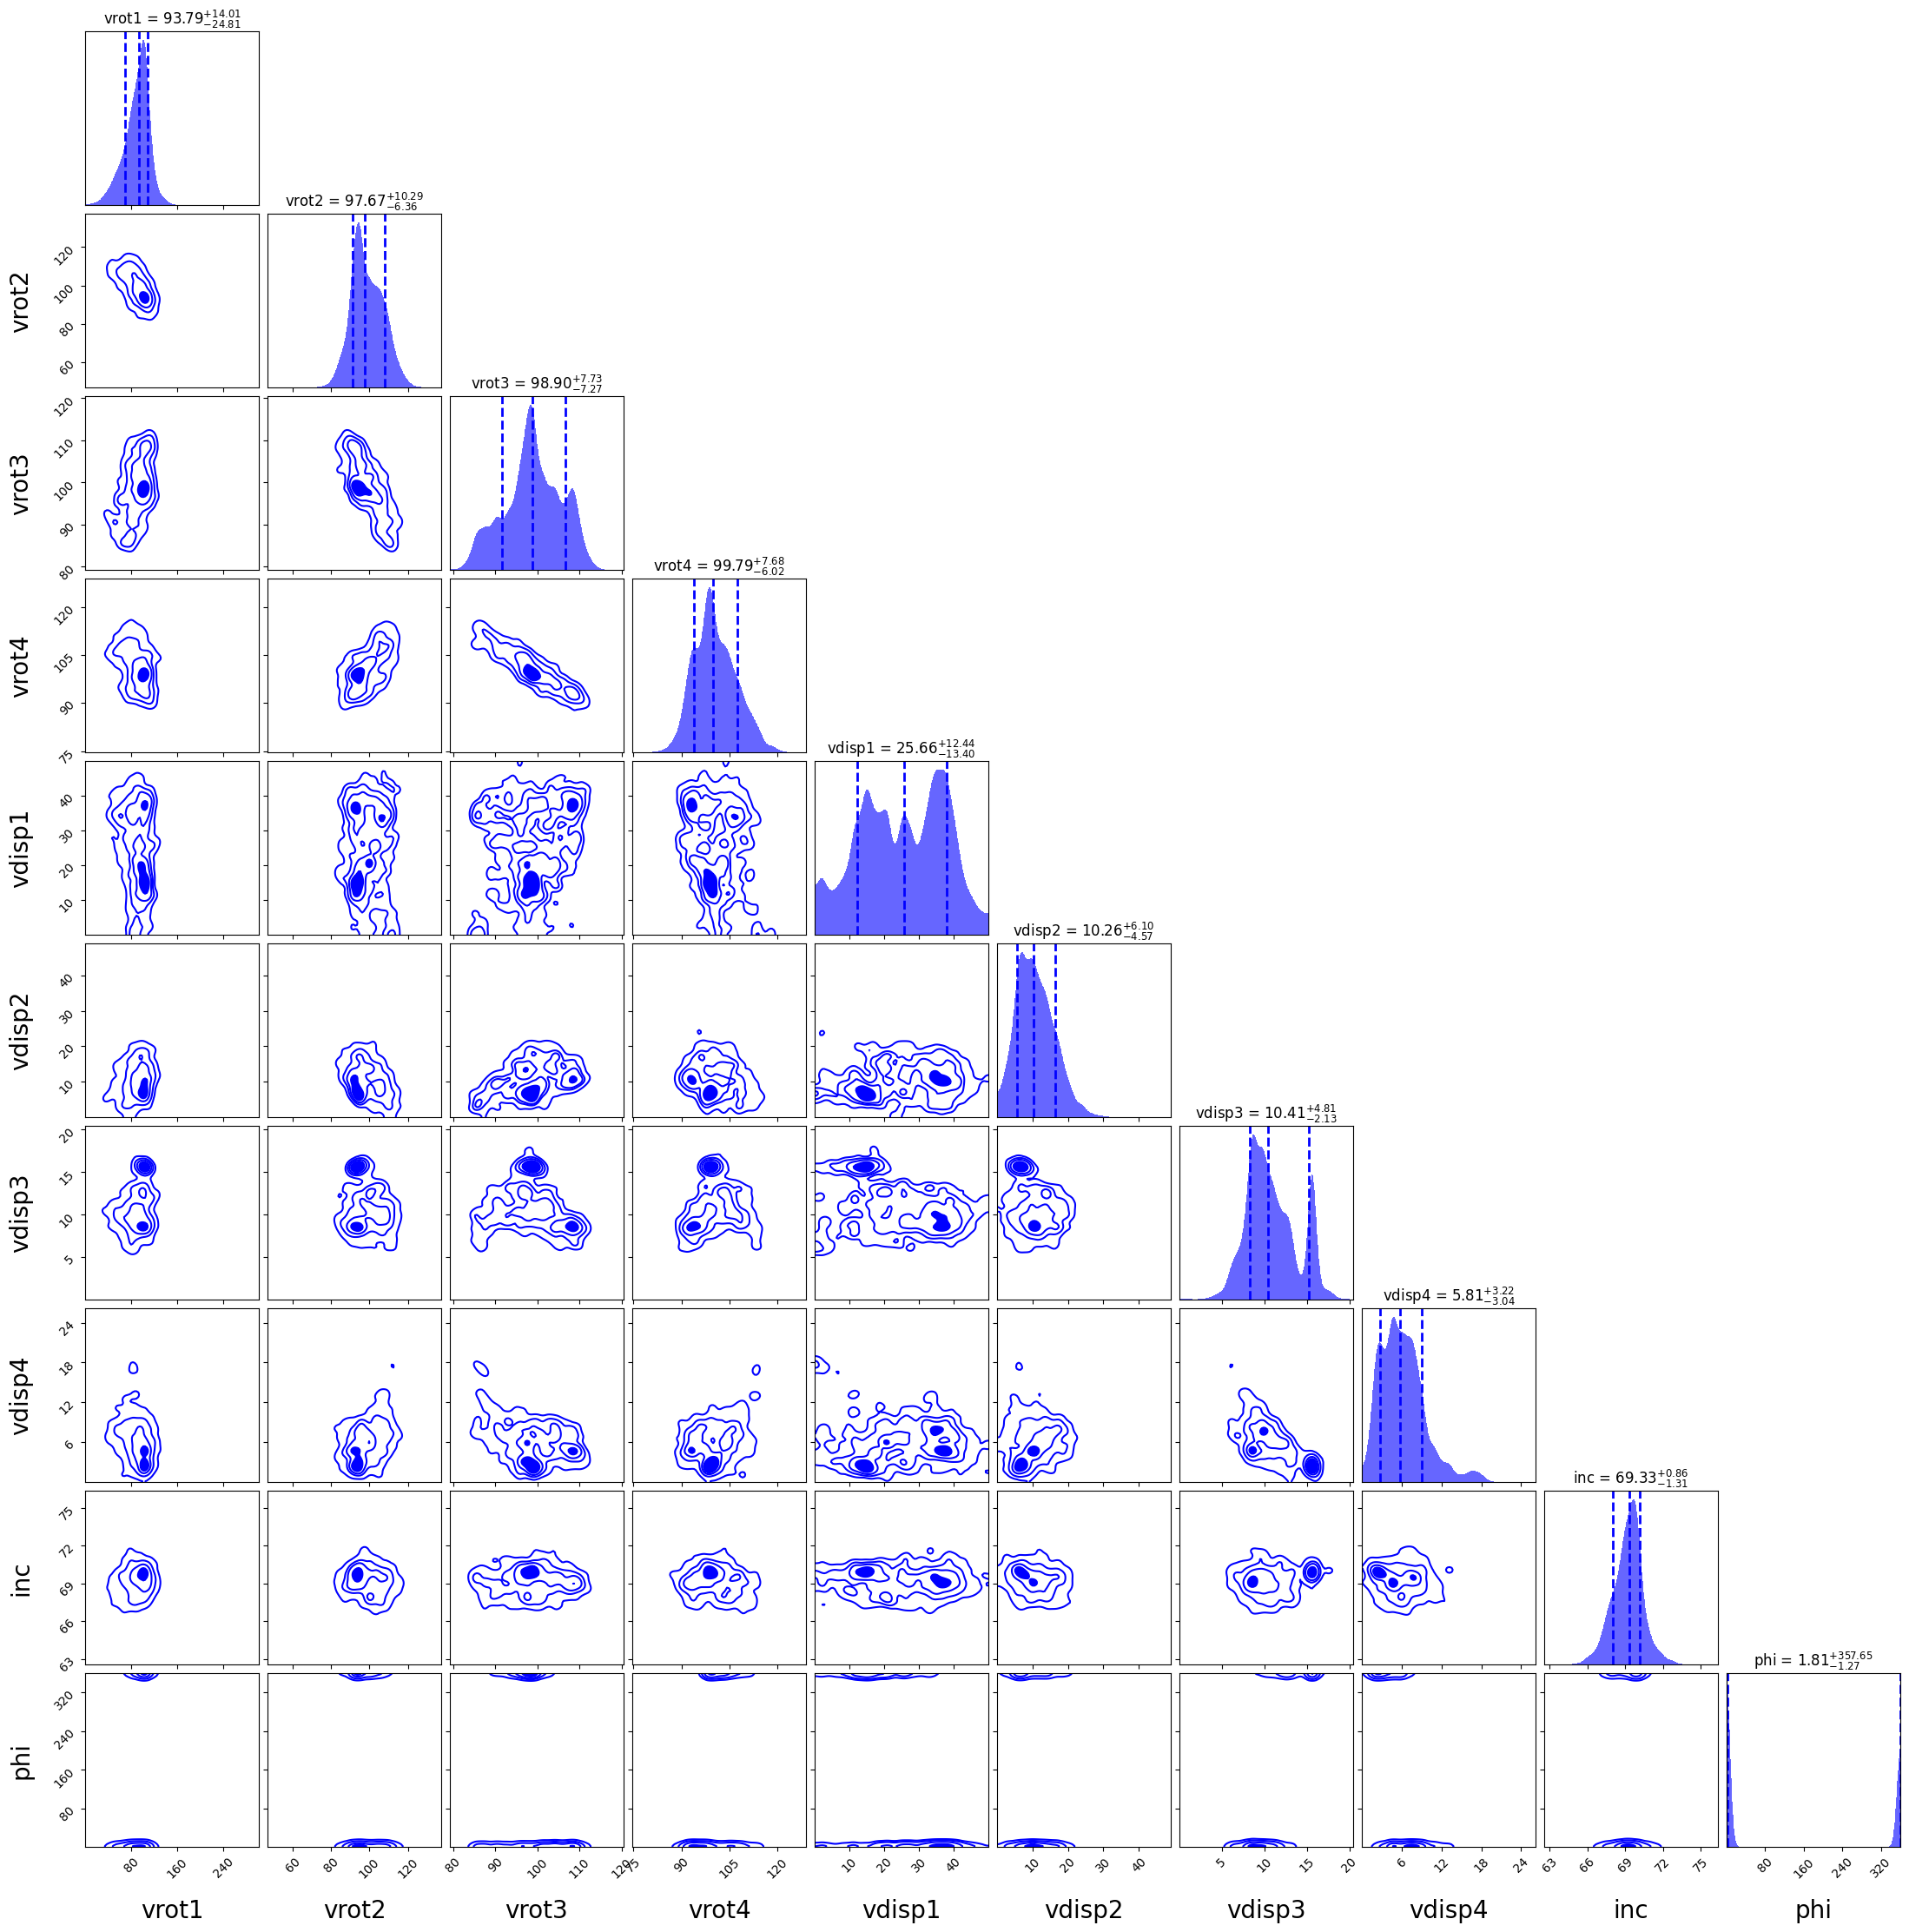

In [12]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84]
cfig, caxes = dyplot.cornerplot(f3d.results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, \
                                labels=f3d.freepar_names, label_kwargs=dict(fontsize=20))
cfig.savefig(f'{output}/{model}/{model}_corner.pdf',bbox_inches='tight')

# Saving samples
np.save("dynesty_samples.npy", f3d.results.samples)

In [13]:
del f3d
gc.collect()

10816